# Predicting Financial Crisis: Study B x Processing 1

Using the Financial Crises dataset: characterize/describe the dataset and compare various classification models (e.g., Logistic regression, SVM, NN, classification trees/forests, ... ) in terms of their ability to correctly predict financial crises. Make sure to treat this as a real-time prediction problem: when predicting financial crises is a given year t, you can only use features from previous years t-s (with s>0), but no contemporaneous variables from the same year t. Compare the quality of your predictions using different criteria and validation methods.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_squared_error, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
df = pd.read_csv('FinancialCrises.csv')
del df['govass']

In [23]:
wars = np.concatenate((np.arange(1914,1920,1) , np.arange(1920,1926,1), np.arange(1939,1948,1)), axis=0)

## Data Processing

In [24]:
df1 = df.loc[df['country'] == 'DNK']
df2 = df.loc[df['country'] == 'AUS']
df3 = df.loc[df['country'] == 'JPN']
df4 = df.loc[df['country'] == 'ESP']
df5 = df.loc[df['country'] == 'GBR']
df6 = df.loc[df['country'] == 'SWE']
df7 = df.loc[df['country'] == 'FRA']
df8 = df.loc[df['country'] == 'NOR']
df9 = df.loc[df['country'] == 'USA']
df10 = df.loc[df['country'] == 'ITA']
df11 = df.loc[df['country'] == 'DEU']
df12 = df.loc[df['country'] == 'CAN']
df13 = df.loc[df['country'] == 'NLD']
df14 = df.loc[df['country'] == 'CHE']

In [25]:
def df_process(df):
    df = df.dropna()
    df = df.sort_values(by=['country', 'year'])
    df['credit_growth'] = np.log(df['loans1']).diff() - np.log(df['cpi']).diff()
    return df

In [26]:
df1 = df_process(df1)
df2 = df_process(df2)
df3 = df_process(df3)
df4 = df_process(df4)
df5 = df_process(df5)
df6 = df_process(df6)
df7 = df_process(df7)
df8 = df_process(df8)
df9 = df_process(df9)
df10 = df_process(df10)
df11 = df_process(df11)
df12 = df_process(df12)
df13 = df_process(df13)
df14 = df_process(df14)

In [27]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14])
enc = LabelEncoder()
df['country'] = enc.fit_transform(df['country'])

In [28]:
scaled_features = ['rgdpbarro', 'rgdp', 'loans1', 'bassets2', 'narrowm',
       'money', 'gdp', 'iy', 'cpi', 'pop', 'stir', 'ltrate', 'stocks', 'credit_growth']
not_scaled_features = ['year', 'country', 'crisisST']
scale = StandardScaler()
df1 = pd.DataFrame(scale.fit_transform(df[scaled_features]), columns = scaled_features, index = df.index)
df2 = df[not_scaled_features]
df = df1.merge(df2, left_index = True, right_index = True)
df = df.sort_values(by=['year', 'country'])

In [29]:
for i in range(len(wars)):
    df = df.loc[df['year'] != wars[i]]

In [30]:
df = df.dropna()
df = df.sort_values(by=['year', 'country'])

## Models

In [32]:
n = 3
df = df.set_index(np.arange(len(df)))

In [14]:
df.head()

rgdpbarro      rgdp    loans1  bassets2   narrowm     money       gdp  \
0  -1.379891 -1.318650 -0.137390 -0.146371 -0.130077 -0.152272 -0.155687   
1  -1.374411 -1.299619 -0.137385 -0.146366 -0.130074 -0.152268 -0.155677   
2  -1.378900 -1.292471 -0.137379 -0.146362 -0.130077 -0.152264 -0.155671   
3  -1.376055 -1.306435 -0.137377 -0.146361 -0.130081 -0.152263 -0.155673   
4  -1.025687 -1.010352 -0.137401 -0.146385 -0.130098 -0.152292 -0.155746   

         iy       cpi       pop      stir    ltrate    stocks  credit_growth  \
0 -1.059112 -0.941230 -0.741855 -0.425937 -0.425524 -0.316144       0.136475   
1 -0.366026 -0.936778 -0.741000 -0.278059 -0.368177 -0.316148       0.133968   
2 -0.348864 -0.934870 -0.740163 -0.107655 -0.439177 -0.316154       0.142923   
3 -0.323030 -0.935506 -0.739399  0.003570 -0.478645 -0.316159       0.060841   
4 -0.371068 -0.939804 -0.783662 -0.254134 -0.508201 -0.314684       0.034642   

   year  country  crisisST  
0  1872       12         0  
1  1873       12         0  
2  1874       12         0  
3  1875       12         0  
4  1876        0         0

### Logistic Regression

In [33]:
clf = LogisticRegression(max_iter = 200, solver = 'newton-cg')

In [34]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [35]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.7745901639344261
Confusion_Matrix 1
[[243   1]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6172839506172838
Confusion_Matrix 2
[[240   3]
 [  7   1]]
--------------------------------------------------------------------------------
AUC Score: 0.4989539748953975
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8507025761124121
Confusion_Matrix 1
[[233  11]
 [  4   3]]
--------------------------------------------------------------------------------
AUC Score: 0.5324074074074074
Confusion_Matrix 2
[[231  12]
 [  7   1]]
--------------------------------------------------------------------------------
AUC Score: 0.5244072524407253
Confusion_Matrix 3
[[233   6]
 [ 10   2]]


(None, None)

### Plots

Average precision-recall score: 0.19


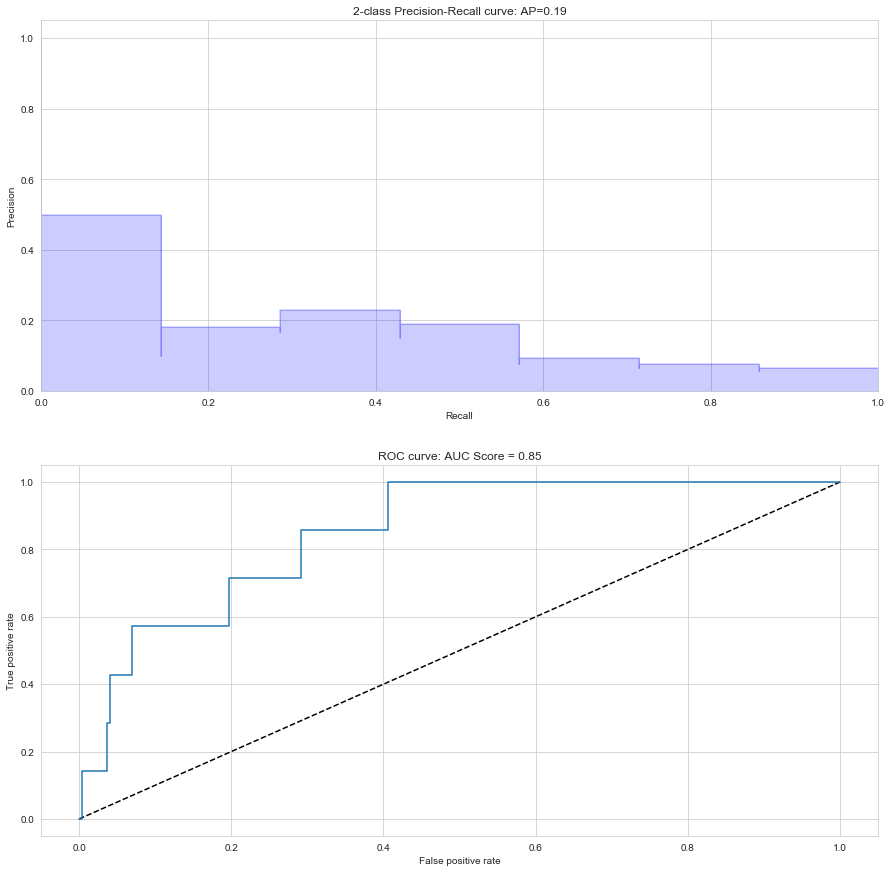

In [36]:
y_score = proba_sm[0]
y_test = y_t[0]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.subplot(2,1,2)
fpr, tpr, _ = roc_curve(y_test, y_score)
auc_score = roc_auc_score(y_test, y_score)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: AUC Score = {0:0.2f}'.format(
          auc_score))
plt.show()

### Random Forest Classifier

In [19]:
clf = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2,
                            n_estimators = 500)

In [20]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [21]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.540983606557377
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6779835390946503
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5111576011157601
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5942622950819673
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5313786008230452
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5831589958158996
Confusion_Matrix 3
[[235   4]
 [ 12   0]]


(None, None)

### Plots

Average precision-recall score: 0.13


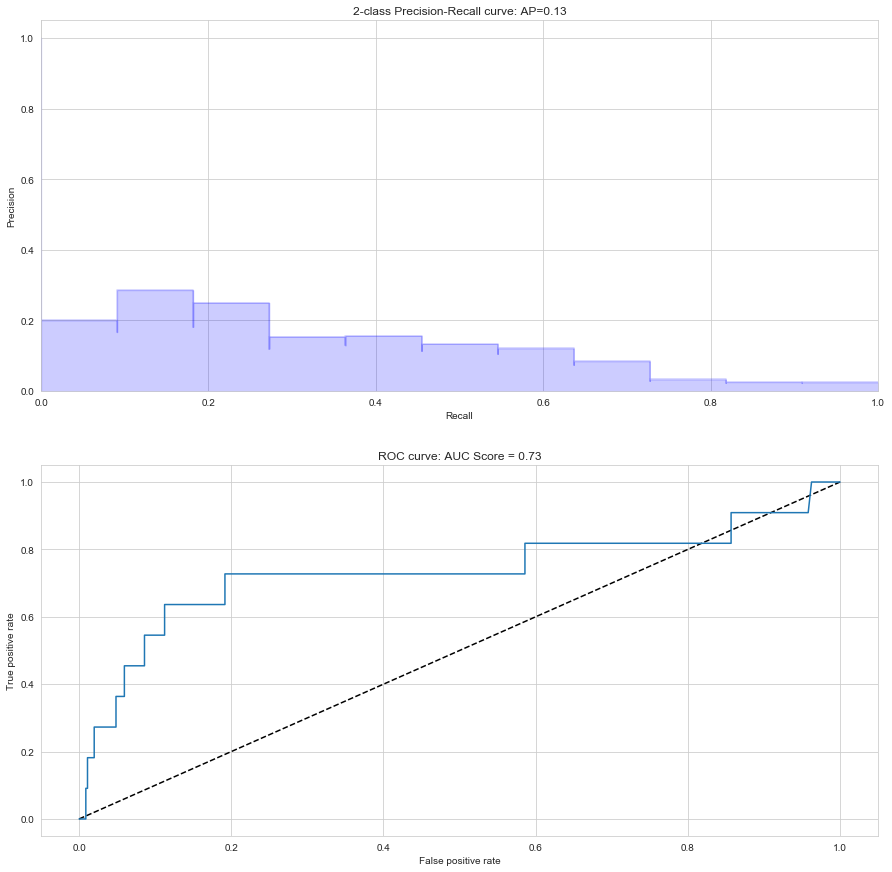

In [17]:
y_score = proba_sm[2]
precision, recall, thresholds = precision_recall_curve(y_t[2], y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_t[2], y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.subplot(2,1,2)
fpr, tpr, _ = roc_curve(y_t[2], y_score)
auc_score = roc_auc_score(y_t[2], y_score)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: AUC Score = {0:0.2f}'.format(
          auc_score))
plt.show()

### Extra-Trees Classifier

In [22]:
clf = ExtraTreesClassifier(criterion = 'entropy', max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2,
                            n_estimators = 500)

In [23]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [24]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.29215456674473067
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7037037037037037
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5322524407252441
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.42798594847775173
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5823045267489712
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5781032078103208
Confusion_Matrix 3
[[234   5]
 [ 12   0]]


(None, None)

### Decision Tree Classifier

In [25]:
clf = DecisionTreeClassifier()

In [26]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [27]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.4294496487119438
Confusion_Matrix 1
[[105 139]
 [  4   3]]
--------------------------------------------------------------------------------
AUC Score: 0.49588477366255146
Confusion_Matrix 2
[[241   2]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4916317991631799
Confusion_Matrix 3
[[235   4]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.3790983606557377
Confusion_Matrix 1
[[185  59]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4916317991631799
Confusion_Matrix 3
[[235   4]
 [ 12   0]]


(None, None)

### BaggingClassifier

In [28]:
clf = BaggingClassifier()

In [29]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [30]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.27195550351288056
Confusion_Matrix 1
[[123 121]
 [  5   2]]
--------------------------------------------------------------------------------
AUC Score: 0.702417695473251
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.46234309623430964
Confusion_Matrix 3
[[235   4]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.35597189695550346
Confusion_Matrix 1
[[239   5]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4609053497942387
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.46234309623430964
Confusion_Matrix 3
[[237   2]
 [ 12   0]]


(None, None)

### AdaBoost Classifier

In [31]:
clf = AdaBoostClassifier()

In [32]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [33]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.681791569086651
Confusion_Matrix 1
[[228  16]
 [  6   1]]
--------------------------------------------------------------------------------
AUC Score: 0.54809670781893
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5934449093444909
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.8416276346604216
Confusion_Matrix 1
[[243   1]
 [  6   1]]
--------------------------------------------------------------------------------
AUC Score: 0.4678497942386831
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6514993026499303
Confusion_Matrix 3
[[228  11]
 [ 11   1]]


(None, None)

### GradientBoostingClassifier

In [34]:
clf = GradientBoostingClassifier()

In [35]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [36]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.2543911007025761
Confusion_Matrix 1
[[133 111]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6790123456790123
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5559623430962344
Confusion_Matrix 3
[[236   3]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4279859484777518
Confusion_Matrix 1
[[242   2]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.45884773662551437
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.539400278940028
Confusion_Matrix 3
[[235   4]
 [ 12   0]]


(None, None)

### XGBoost Classifier

In [37]:
clf = XGBClassifier()

In [38]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [39]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.6902810304449648
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.621656378600823
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.548465829846583
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.623536299765808
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.47247942386831276
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5725244072524407
Confusion_Matrix 3
[[235   4]
 [ 12   0]]


(None, None)

### KNeighbors Classifier

In [40]:
clf = KNeighborsClassifier(5)

In [41]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [42]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5670374707259952
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4874476987447699
Confusion_Matrix 3
[[239   0]
 [ 12   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5822599531615925
Confusion_Matrix 1
[[241   3]
 [  6   1]]
--------------------------------------------------------------------------------
AUC Score: 0.5
Confusion_Matrix 2
[[243   0]
 [  8   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5247559274755927
Confusion_Matrix 3
[[236   3]
 [ 12   0]]


(None, None)

### Naive Bayes

In [43]:
clf = GaussianNB()

In [44]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [45]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5579625292740047
Confusion_Matrix 1
[[219  25]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.48431069958847733
Confusion_Matrix 2
[[236   7]
 [  7   1]]
--------------------------------------------------------------------------------
AUC Score: 0.46652719665271963
Confusion_Matrix 3
[[196  43]
 [ 10   2]]
--------------------------------------------------------------------------------
AUC Score: 0.6329039812646371
Confusion_Matrix 1
[[244   0]
 [  7   0]]
--------------------------------------------------------------------------------
AUC Score: 0.4441872427983539
Confusion_Matrix 2
[[237   6]
 [  7   1]]
--------------------------------------------------------------------------------
AUC Score: 0.45955369595536966
Confusion_Matrix 3
[[164  75]
 [  9   3]]


(None, None)

### Linear Discriminant Analysis

In [42]:
clf = LinearDiscriminantAnalysis()

In [43]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [44]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5243599304001989
Confusion_Matrix 1
[[447   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6252821670428893
Confusion_Matrix 2
[[443   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5746896275530637
Confusion_Matrix 3
[[454   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5213770817797663
Confusion_Matrix 1
[[341 106]
 [ 11   7]]
--------------------------------------------------------------------------------
AUC Score: 0.6311307202955058
Confusion_Matrix 2
[[407  36]
 [ 18   4]]
--------------------------------------------------------------------------------
AUC Score: 0.592110532639167
Confusion_Matrix 3
[[454   0]
 [ 11   0]]


(None, None)

### Quadratic Discriminant Analysis

In [45]:
clf = QuadraticDiscriminantAnalysis()

In [46]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [47]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5321899080288341
Confusion_Matrix 1
[[246 201]
 [  8  10]]
--------------------------------------------------------------------------------
AUC Score: 0.5983993433203365
Confusion_Matrix 2
[[156 287]
 [  4  18]]
--------------------------------------------------------------------------------
AUC Score: 0.566079295154185
Confusion_Matrix 3
[[ 21 433]
 [  0  11]]
--------------------------------------------------------------------------------
AUC Score: 0.5031071339796171
Confusion_Matrix 1
[[247 200]
 [  9   9]]
--------------------------------------------------------------------------------
AUC Score: 0.6073260824953827
Confusion_Matrix 2
[[105 338]
 [  2  20]]
--------------------------------------------------------------------------------
AUC Score: 0.5574689627553064
Confusion_Matrix 3
[[ 22 432]
 [  0  11]]


(None, None)

### SVM Classifier

In [48]:
clf = svm.SVC(decision_function_shape='ovo', probability=True)

In [49]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [50]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.46358438975888644
Confusion_Matrix 1
[[447   0]
 [ 18   0]]
--------------------------------------------------------------------------------
AUC Score: 0.7072645187769341
Confusion_Matrix 2
[[443   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6357629154985983
Confusion_Matrix 3
[[454   0]
 [ 11   0]]
--------------------------------------------------------------------------------
AUC Score: 0.5166542381307482
Confusion_Matrix 1
[[377  70]
 [ 16   2]]
--------------------------------------------------------------------------------
AUC Score: 0.7390211368766674
Confusion_Matrix 2
[[387  56]
 [ 12  10]]
--------------------------------------------------------------------------------
AUC Score: 0.7747296756107329
Confusion_Matrix 3
[[430  24]
 [  7   4]]


(None, None)

### SGD Classifier

In [51]:
clf = SGDClassifier(loss = 'log')

In [52]:
AUC_LR_sm = []
AUC_LR = []
proba_sm = []
proba = []
y_t = []
y = df['crisisST'].values
X = df.drop(['crisisST'], axis=1).values
scaler = StandardScaler()
X  = scaler.fit_transform(X)
sm = SMOTE(0.5,random_state=42)
tscv = TimeSeriesSplit(n_splits=n)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_t.append(y_test)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    clf.fit(X_train_sm, y_train_sm)
    y_proba1 = clf.predict_proba(X_test)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    AUC_LR.append(roc_auc_score(y_test, y_proba[:,1]))
    proba.append(list(y_proba[:,1]))
    AUC_LR_sm.append(roc_auc_score(y_test, y_proba1[:,1]))
    proba_sm.append(list(y_proba1[:,1]))

In [53]:
def conf_mat(prob, AUC):
    for i in range(n):
        y_pred = []
        for j in range(len(prob[i])):
            if prob[i][j]>0.5:
                y_pred.append(1)
            else: 
                y_pred.append(0)
        print( "-"*80)
        print('AUC Score:', AUC[i])
        print('Confusion_Matrix', i+1)
        print(confusion_matrix(y_t[i],y_pred))
conf_mat(proba, AUC_LR), conf_mat(proba_sm, AUC_LR_sm)

--------------------------------------------------------------------------------
AUC Score: 0.5584141188168035
Confusion_Matrix 1
[[417  30]
 [ 17   1]]
--------------------------------------------------------------------------------
AUC Score: 0.6227170121075313
Confusion_Matrix 2
[[443   0]
 [ 22   0]]
--------------------------------------------------------------------------------
AUC Score: 0.6105326391670004
Confusion_Matrix 3
[[422  32]
 [  9   2]]
--------------------------------------------------------------------------------
AUC Score: 0.5584141188168033
Confusion_Matrix 1
[[348  99]
 [ 11   7]]
--------------------------------------------------------------------------------
AUC Score: 0.5697722142417402
Confusion_Matrix 2
[[200 243]
 [  8  14]]
--------------------------------------------------------------------------------
AUC Score: 0.5504605526631958
Confusion_Matrix 3
[[290 164]
 [  7   4]]


(None, None)